<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.patches import Polygon
from matplotlib.ticker import MultipleLocator

import seaborn as sns
import scipy as sp
from scipy import signal
from scipy.interpolate import griddata

from datetime import timedelta, datetime
import warnings
from IPython.display import display, Math
warnings.filterwarnings('ignore')

mint = 60
hour = 3600

In [3]:
def mask_outside_polygon(poly_verts, ax=None):
    """
    Plots a mask on the specified axis ("ax", defaults to plt.gca()) such that
    all areas outside of the polygon specified by "poly_verts" are masked.  

    "poly_verts" must be a list of tuples of the verticies in the polygon in
    counter-clockwise order.

    Returns the matplotlib.patches.PathPatch instance plotted on the figure.
    """
    import matplotlib.patches as mpatches
    import matplotlib.path as mpath

    if ax is None:
        ax = plt.gca()

    # Get current plot limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Verticies of the plot boundaries in clockwise order
    bound_verts = [(xlim[0], ylim[0]), (xlim[0], ylim[1]), 
                   (xlim[1], ylim[1]), (xlim[1], ylim[0]), 
                   (xlim[0], ylim[0])]

    # A series of codes (1 and 2) to tell matplotlib whether to draw a line or 
    # move the "pen" (So that there's no connecting line)
    bound_codes = [mpath.Path.MOVETO] + (len(bound_verts) - 1) * [mpath.Path.LINETO]
    poly_codes = [mpath.Path.MOVETO] + (len(poly_verts) - 1) * [mpath.Path.LINETO]

    # Plot the masking patch
    path = mpath.Path(bound_verts + poly_verts, bound_codes + poly_codes)
    patch = mpatches.PathPatch(path, facecolor='white', edgecolor='none')
    patch = ax.add_patch(patch)

    # Reset the plot limits to their original extents
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return patch

# Importing Data

## Get Station Number as a Function of Longitudes and Latitudes

In [4]:
lon_and_lat = np.genfromtxt('AllStations_temperature_h_2017.dat', delimiter=" ", max_rows=2)
longitudes = lon_and_lat[0][~np.isnan(lon_and_lat[0])]
latitudes = lon_and_lat[1][~np.isnan(lon_and_lat[1])]

indices = list(zip(np.array(longitudes), np.array(latitudes)))
indices.insert(0, "time")

Dictionary that provides the mapping:

In [5]:
location_to_station_num = dict(zip(indices[1::], np.arange(0,37)))

## Import Data

In [6]:
winter_df = pd.read_pickle('Dataframes/winter_2017.pkl')
summer_df = pd.read_pickle('Dataframes/summer_2017.pkl')

In [7]:
winter_stations = np.array([location_to_station_num[winter_df.columns[i]] for i in range(len(winter_df.columns))])
summer_stations = np.array([location_to_station_num[summer_df.columns[i]] for i in range(len(summer_df.columns))])

In [8]:
summer_stations

array([ 1,  2,  3,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 22, 23,
       24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36])

Check to make sure data is okay

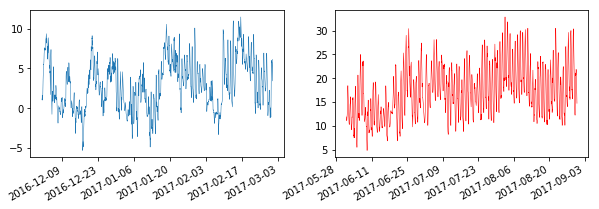

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))

winter_df.iloc[:,0].plot(ax = ax[0], lw=0.5)
summer_df.iloc[:,0].plot(ax = ax[1], color='r', lw=0.5)

plt.show()

# Filter Functions

In [10]:
def ellip_bandpass(lowcut, highcut, fs, rp, rs, order=5, btype='bandpass'):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if (btype == 'bandpass'):
        b, a = sp.signal.ellip(order, rp, rs, [low, high], btype=btype)
    if (btype == 'lowpass'):
        b, a = sp.signal.ellip(order, rp, rs, low, btype=btype)
    if (btype == 'highpass'):
        b, a = sp.signal.ellip(order, rp, rs, high, btype=btype)
        
    return b, a

def ellip_bandpass_filter(data, value, diff_low, diff_high, fs, rp, rs, order=5):
    
    #filter high signals
    b, a = ellip_bandpass(value+diff_low, value+diff_high, fs, rp, rs, order=order, btype='lowpass')
    y = signal.filtfilt(b, a, data)
    
    #filter low signals
    b, a = ellip_bandpass(value-diff_high, value-diff_low, fs, rp, rs, order=order, btype='highpass')
    y = signal.filtfilt(b, a, y)
    
    return y

This function takes in a column of the dataframe and returns the diurnal percentage. Uses the filter from assignment 5.

In [11]:
def get_n_hour_percent(df, n, diff_low_scale, diff_high_scale, order=3):
    
    diurnal_percents = []
    
    for column in df:
        data = np.array(df[column])
        data_diurnal = ellip_bandpass_filter(data, value=1/(n*hour), diff_low=diff_low_scale/(n*hour),
                                             diff_high=diff_high_scale/(n*hour), fs=1/hour, rp=2, rs=50, order=order)   
        diurnal_percent = 100*np.var(data_diurnal)/np.var(data)
        diurnal_percents.append(diurnal_percent)
        
    return diurnal_percents

Get the dirunal components of all stations:

# 24, 12, 8 Hour Frequency

These values were obtained by playing around with filter responses in Assignment5_Modified-> Design the Filter -> Part 1,

In [12]:
winter_24 = get_n_hour_percent(winter_df, 24, 0.15, 0.3)
summer_24 = get_n_hour_percent(summer_df, 24, 0.15, 0.3)
winter_12 = get_n_hour_percent(winter_df, 12, 0.25, 0.5)
summer_12 = get_n_hour_percent(summer_df, 12, 0.25, 0.5)
winter_8 = get_n_hour_percent(winter_df, 8, 0.1, 1, order=5)
summer_8 = get_n_hour_percent(summer_df, 8, 0.1, 1, order=5)

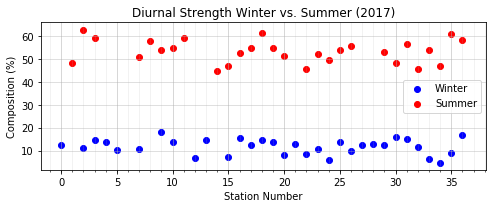

In [13]:
fig, ax = plt.subplots(figsize=(7,3))

ax.scatter(winter_stations, winter_24, color='b', label='Winter')
ax.scatter(summer_stations, summer_24, color='r', label='Summer')

ax.set_xlabel('Station Number')
ax.set_ylabel('Composition (%)')

spacing = 1 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)
ax.xaxis.set_minor_locator(minorLocator)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_title('Diurnal Strength Winter vs. Summer (2017)')

ax.legend()

fig.tight_layout()
plt.savefig('plots/diurnal_strengths.png', dpi=200)
plt.show()

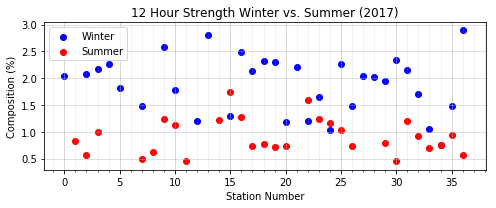

In [14]:
fig, ax = plt.subplots(figsize=(7,3))

ax.scatter(winter_stations, winter_12, color='b', label='Winter')
ax.scatter(summer_stations, summer_12, color='r', label='Summer')

ax.set_xlabel('Station Number')
ax.set_ylabel('Composition (%)')

spacing = 1 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)
ax.xaxis.set_minor_locator(minorLocator)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_title('12 Hour Strength Winter vs. Summer (2017)')

ax.legend()

fig.tight_layout()
plt.savefig('plots/12hr_strengths.png', dpi=200)
plt.show()

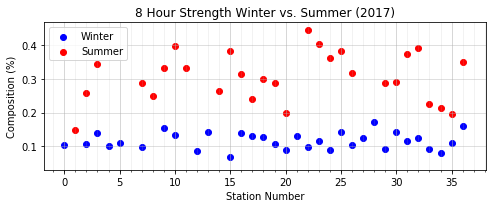

In [15]:
fig, ax = plt.subplots(figsize=(7,3))

ax.scatter(winter_stations, winter_8, color='b', label='Winter')
ax.scatter(summer_stations, summer_8, color='r', label='Summer')

ax.set_xlabel('Station Number')
ax.set_ylabel('Composition (%)')

spacing = 1 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)
ax.xaxis.set_minor_locator(minorLocator)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_title('8 Hour Strength Winter vs. Summer (2017)')

ax.legend()

fig.tight_layout()
plt.savefig('plots/8hr_strengths.png', dpi=200)
plt.show()

# Print Statistics

In [16]:
print('Winter 8 hour percent {:.3f}'.format(np.mean(winter_8)))
print('Winter 12 hour percent {:.3f}'.format(np.mean(winter_12)))
print('Winter 24 hour percent {:.3f}'.format(np.mean(winter_24)))

Winter 8 hour percent 0.117
Winter 12 hour percent 1.879
Winter 24 hour percent 11.760


In [17]:
print('Summer 8 hour percent {:.3f}'.format(np.mean(summer_8)))
print('Summer 12 hour percent {:.3f}'.format(np.mean(summer_12)))
print('Summer 24 hour percent {:.3f}'.format(np.mean(summer_24)))

Summer 8 hour percent 0.306
Summer 12 hour percent 0.917
Summer 24 hour percent 53.428


In [18]:
lons, lats = zip(*winter_df.columns)
df__ = pd.DataFrame(data=[lons, lats, winter_8, winter_12, winter_24], index = ['Longitude', 'Latitude', '8', '12', '24']).T
df__.to_pickle('Dataframes/winter_2017_diurnal_bois')
df__.head()

,Longitude,Latitude,8,12,24
0,236.554,48.5745,0.103909,2.037117,12.220632
1,236.679,48.4655,0.105980,2.071228,10.897378
2,236.607,48.4608,0.139894,2.177222,14.758528
3,236.514,48.4356,0.102200,2.262476,13.748576
4,236.630,48.5273,0.110193,1.816961,10.368761


In [19]:
lons, lats = zip(*summer_df.columns)
df__ = pd.DataFrame(data=[lons, lats, summer_8, summer_12, summer_24], index = ['Longitude', 'Latitude', '8', '12', '24']).T
df__.to_pickle('Dataframes/summer_2017_diurnal_bois')
df__.head()

,Longitude,Latitude,8,12,24
0,236.499,48.5376,0.149989,0.829379,48.357408
1,236.679,48.4655,0.256710,0.565794,62.892402
2,236.607,48.4608,0.344026,0.991746,59.247136
3,236.543,48.6804,0.289017,0.502250,50.766701
4,236.662,48.4562,0.248781,0.631216,57.840177


In [24]:
summer_df.columns

MultiIndex(levels=[[236.25, 236.283, 236.304, 236.357, 236.43, 236.446, 236.451, 236.471, 236.494, 236.499, 236.514, 236.523, 236.543, 236.554, 236.574, 236.579, 236.595, 236.596, 236.597, 236.604, 236.607, 236.619, 236.63, 236.635, 236.639, 236.641, 236.662, 236.67, 236.672, 236.676, 236.679, 236.686, 236.689, 236.691, 236.7], [48.364, 48.371, 48.3874, 48.3891, 48.4161, 48.4182, 48.4205, 48.4253, 48.4281, 48.4356, 48.4359, 48.4382, 48.4451, 48.4456, 48.4529, 48.4533, 48.4562, 48.4572, 48.4608, 48.4623, 48.4651, 48.4655, 48.4683, 48.4744, 48.4788, 48.4865, 48.5014, 48.5273, 48.5376, 48.5677, 48.5745, 48.6529, 48.6568, 48.66, 48.6701, 48.6804]],
           labels=[[9, 30, 20, 12, 26, 2, 19, 4, 5, 0, 1, 18, 23, 8, 28, 16, 27, 31, 15, 24, 10, 3, 14, 17, 29, 33, 32, 6], [28, 21, 18, 35, 16, 3, 11, 33, 0, 1, 2, 29, 24, 21, 12, 7, 4, 5, 34, 13, 6, 32, 15, 31, 25, 19, 10, 17]])

# Data from 2010-2017

Note that this requires running the program 7 times and looking at the values above.

In [20]:
dates = np.array([2010,2011,2012,2013,2014,2015,2016,2017])
wint8 = np.array([0.105,0.102,0.138,0.212,0.092,0.141,0.124,0.117])
wint12 = np.array([1.586, 1.361, 2.207, 2.600, 1.233, 1.820, 1.743, 1.879])
wint24 = np.array([11.208, 8.815, 11.667, 13.465, 7.994, 13.459, 11.643, 11.760])
sum8 = np.array([0.290, 0.362, 0.272, 0.399, 0.405, 0.344, 0.296, 0.306])
sum12 = np.array([0.945, 1.100, 0.865, 1.241, 1.188, 1.067, 0.872, 0.917])
sum24 = np.array([43.233, 58.884, 44.069, 57.811, 55.136, 54.958, 46.477, 53.428])

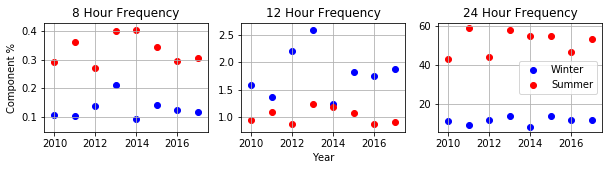

In [21]:
fig, ax = plt.subplots(1,3,figsize=(10,2))

ax[0].scatter(dates,wint8, c='b')
ax[0].scatter(dates,sum8, c='r')

ax[1].scatter(dates,wint12, c='b')
ax[1].scatter(dates,sum12, c='r')

ax[2].scatter(dates, wint24, c='b', label='Winter')
ax[2].scatter(dates,sum24, c='r', label='Summer')

ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[0].set_ylabel('Component %')
ax[1].set_xlabel('Year')

ax[0].set_title('8 Hour Frequency')
ax[1].set_title('12 Hour Frequency')
ax[2].set_title('24 Hour Frequency')

ax[2].legend()

plt.savefig('plots/yearly_freq_comp.png', dpi=200)